<h1>웹 크롤링</h1>

In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait

import time

import pandas as pd
from selenium.webdriver.common.by import By

In [2]:
def get_data(url):
    #웹 드라이버
    driver = webdriver.Chrome(executable_path='chromedriver')
    driver.implicitly_wait(5)
    driver.get(url)
    while True:
        try:
            더보기 = driver.find_element(By.CSS_SELECTOR,'a.u_cbox_btn_more')
            더보기.click()
            time.sleep(1)
        except:
            break
    print("끝")
    
    contents = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_contents')
    
    contents = [content.text for content in contents]
    #작성자 추출
    nicks = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_nick')
    
    nicks = [nick.text for nick in nicks]
    #날짜 추출
    dates = driver.find_elements(By.CSS_SELECTOR,'span.u_cbox_date')
    
    dates = [date.text for date in dates]

    #취합
    data = [data for data in list(zip(nicks,dates, contents))]
    driver.quit()
    return data

In [3]:
if __name__ == '__main__':
    url = "https://n.news.naver.com/article/comment/015/0004802786"
    data = get_data(url)
    # print(data)

끝


In [4]:
data[:5]

[('beul****',
  '2023.01.25. 09:56',
  '초딩도 아닌 유아에게 10번물어봤다고?? 난 또 전문가에게 10번 확인받았다는 얘긴 줄. 애들은 부모가 함께면 100미터 수심도 들어갈 수 있다 대답함. 판단은 성인인 부모몫이지. 무사히 하신했으니 다행인데 부모의 버킷리스트에 아이끼워넣진 말자'),
 ('yumc****', '2023.01.25. 09:54', '지기 모유로 비누 만들어 승리한테 준 사람인데 특이한 정신세계'),
 ('ccli****',
  '2023.01.25. 08:39',
  '작은애5살때 덕유산 곤돌라에서 내려 향적봉까지 600 미터정도 업고 가는것도 힘들고, 한라산백록담은 나혼자가는것도 힘들더만 ㅡ 대단하신 모친이시네요.'),
 ('into****',
  '2023.01.25. 08:51',
  '인스타그램이 이시영을 중독으로 빠져들게 한것 같다. 숫자 올라가는 중독은 무시 못하지요. 이 기사가 안나왔으면 이시영씨는 더 자극적이고, 더 난도있고, 갈 수록 협오스런 인증샷 등으로 점점 나락으로 떨어졌을듯. 이시영시 본인은 물론 그런줄 모르겠지만요. 마약과 같은 중독....! 이 참에 이시영씨 절제하고 맘을 조금 내려 놓으세요. 인스타 그게 돈 되겠죠?... 하지만 아이 까지 팔아서 인스타 숫자 오르는 기획은 아니라고봄.'),
 ('isab****',
  '2023.01.25. 09:51',
  '아들한테 10번 물어볼게 아니라 안전전문가의 의견을 들어보고 결정하셔야죠...')]

In [5]:
col = ["작성자","날짜","댓글내용"]
data_frame=pd.DataFrame(data,columns=col)
data_frame.to_csv("new_crawling.csv",mode='w',index = False)

<h1>모델학습</h1>

In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, AdamW, get_scheduler

import torch
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

In [ ]:
# 데이터 셋 적재
raw_datasets = load_dataset("nsmc")
# 사전학습 언어모델 checkpoint 이름 지정
checkpoint = "monologg/koelectra-base-v3-generator"
# 지정된 사전학습 언어모델에서 토크나이저 인스턴스화
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


# 토크나이저 함수 사용자 정의화 (sentence1, sentence2 컬럼에 대해서만 토크나이징 수행)
def tokenize_function(example):
    return tokenizer(example["document"], truncation=True)


# 토크나이징 수행
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
# 배치(batch)별 패딩(padding)을 위한 data collator 정의
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 불필요한 입력 컬럼을 제거하고 사전학습 언어모델에 필요한 입력만 남김.
tokenized_datasets = tokenized_datasets.remove_columns(["id", "document"])
# 데이터셋의 label 컬럼명을 labels로 변경
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
# 데이터셋의 유형을 PyTorch tensor로 변경
tokenized_datasets.set_format("torch")

# 변경된 컬럼 출력
print(tokenized_datasets["train"].column_names)


# 각 종류별 데이터 로더 생성
train_dataloader = DataLoader(tokenized_datasets["train"], 
                              shuffle=True, 
                              batch_size=64, 
                              collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets["test"],
                             shuffle=True,
                             batch_size=64,
                             collate_fn=data_collator)

# 사전학습 언어모델 인스턴스화
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
# 최적화 함수 정의
optimizer = AdamW(model.parameters(), lr=5e-5)

# 에포크 개수 설정
num_epochs = 10
# 학습 스텝 수 계산
num_training_steps = num_epochs * len(train_dataloader)
# 학습 스케쥴러 설정
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
# GPU로 모델을 이동
device  = torch.device("mps")
model.to(device)

# 진행 상황바 정의
progress_bar = tqdm(range(num_training_steps))

# 모델을 학습 모드로 전환
model.train()
# 학습 루프 시작
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # 현재 배치 중에서 입력값을 모두 GPU로 이동.
        batch = {k: v.to(device) for k, v in batch.items()}
        # 모델 실행
        outputs = model(**batch)
        # 손실값 가져오기
        loss = outputs.loss
        # 역전파 수행
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
import sklearn
# 평가 메트릭 가져오기
model.to(device)
metric = load_metric('accuracy')#'accuracy'
# 모델을 평가 모드로 전환
model.eval()
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

# 평가 결과 계산 및 출력 
metric.compute()

In [ ]:
import sklearn
# 평가 메트릭 가져오기
model.to(device)
metric = load_metric('accuracy')#'accuracy'
# 모델을 평가 모드로 전환
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

# 평가 결과 계산 및 출력 
metric.compute()

In [ ]:
# 모델 저장 변수 이름.save_pretrained(원하는 디렉토리) 형태
model.save_pretrained('./models_param/model.pt')

<h1>데이터 평가</h1>

In [6]:
#데이터 불러오기
dataset = pd.read_csv("new_crawling.csv", index_col=0)
test = [test for test in dataset["댓글내용"]]
print("댓글 갯수 : ",len(dataset["댓글내용"]))
# test

댓글 갯수 :  712


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('./models_param/model.pt')
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-generator")



In [8]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer)

In [9]:
#1 == pos , 0 == neg
print(classifier("이 영화 진짜 재미있다."))
print(classifier("다음에도 보고 싶은 영화였다"))
print(classifier("와 진짜 대박이다 영화 꿀잼이네"))
print(classifier("재미있긴 한데 좀 아쉽네..."))
print(classifier("진짜 멋져요"))
print(classifier("재미없진 않은데 나는 보통이다"))
print(classifier("그냥저냥 보통인데?"))
print(classifier("와 진짜 진짜 재미 없다"))
print(classifier("아 더빙 ...진짜 짜증나네 목소리"))

[{'label': 'LABEL_1', 'score': 0.9868239164352417}]
[{'label': 'LABEL_1', 'score': 0.9988049268722534}]
[{'label': 'LABEL_1', 'score': 0.9664960503578186}]
[{'label': 'LABEL_1', 'score': 0.7861276865005493}]
[{'label': 'LABEL_1', 'score': 0.9959944486618042}]
[{'label': 'LABEL_0', 'score': 0.9991046786308289}]
[{'label': 'LABEL_0', 'score': 0.996759831905365}]
[{'label': 'LABEL_0', 'score': 0.9987032413482666}]
[{'label': 'LABEL_0', 'score': 0.9994650483131409}]


In [10]:
# classifier를 통한 긍부정 평가 진행
answer_data = [classifier(answer_data) for answer_data in test]

In [11]:
answer = [data for data in list(zip(test, answer_data))]

In [12]:
answer

[('초딩도 아닌 유아에게 10번물어봤다고?? 난 또 전문가에게 10번 확인받았다는 얘긴 줄. 애들은 부모가 함께면 100미터 수심도 들어갈 수 있다 대답함. 판단은 성인인 부모몫이지. 무사히 하신했으니 다행인데 부모의 버킷리스트에 아이끼워넣진 말자',
  [{'label': 'LABEL_0', 'score': 0.9992011189460754}]),
 ('지기 모유로 비누 만들어 승리한테 준 사람인데 특이한 정신세계',
  [{'label': 'LABEL_0', 'score': 0.9993016719818115}]),
 ('작은애5살때 덕유산 곤돌라에서 내려 향적봉까지 600 미터정도 업고 가는것도 힘들고, 한라산백록담은 나혼자가는것도 힘들더만 ㅡ 대단하신 모친이시네요.',
  [{'label': 'LABEL_0', 'score': 0.9966347813606262}]),
 ('인스타그램이 이시영을 중독으로 빠져들게 한것 같다. 숫자 올라가는 중독은 무시 못하지요. 이 기사가 안나왔으면 이시영씨는 더 자극적이고, 더 난도있고, 갈 수록 협오스런 인증샷 등으로 점점 나락으로 떨어졌을듯. 이시영시 본인은 물론 그런줄 모르겠지만요. 마약과 같은 중독....! 이 참에 이시영씨 절제하고 맘을 조금 내려 놓으세요. 인스타 그게 돈 되겠죠?... 하지만 아이 까지 팔아서 인스타 숫자 오르는 기획은 아니라고봄.',
  [{'label': 'LABEL_0', 'score': 0.6183763742446899}]),
 ('아들한테 10번 물어볼게 아니라 안전전문가의 의견을 들어보고 결정하셔야죠...',
  [{'label': 'LABEL_1', 'score': 0.8847438097000122}]),
 ('쟤도 동문서답 죽여주네. 겨울산 등산하는데 애 업고 가는게 여러가지로 위험하다는걸 지적하는데 뭔 뜬금없이 애한테 몇번 물어봤는지를 말해. 겨울산은 멀쩡한 성인이 혼자 등산하다가도 미끄러지거나 넘어져서 부상당하기 쉽상인데 말야.',
  [{'label': 'LABEL_0',

In [13]:
#결과 csv파일 만들기.
col = ["댓글 내용","긍부정 평가 결과"]
data_frame=pd.DataFrame(answer,columns=col)
data_frame.to_csv("answer.csv",mode='w',index = False)

<h1>Matplotlib을 활용한 산출 데이터 분석</h1>

In [14]:
answer[:5]

len_positive = 0
len_negative = 0
neg_score = []
pos_score = []
for i in range(0, len(answer)):
    if answer[i][1][0]["label"] == "LABEL_1":
        len_positive+=1
        pos_score.append(answer[i][1][0]["score"])
    else:
        len_negative+=1
        neg_score.append(answer[i][1][0]["score"])
print(len_positive, len_negative)



364 348


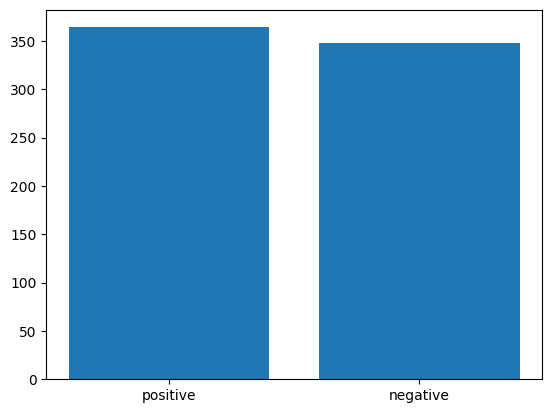

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
name = ['positive', 'negative']
values = [len_positive, len_negative]

plt.bar(x, values)
plt.xticks(x, name)

plt.show()

In [16]:
print(max(neg_score))
print(min(neg_score))
print(max(pos_score))
print(min(pos_score))


0.9997658133506775
0.5126985907554626
0.999771773815155
0.5132421851158142


In [17]:
pos1 = 0
pos2 = 0
pos3 = 0
pos4 = 0
pos5 = 0

for i in pos_score:
    if i >0.5 and i<=0.6:
        pos1+=1
    if i >0.6 and i<=0.7:
        pos2+=1
    if i >0.7 and i<=0.8:
        pos3+=1
    if i >0.8 and i<=0.9:
        pos4+=1
    if i>0.9 and i<=1:
        pos5+=1
neg1 = 0
neg2 = 0
neg3 = 0
neg4 = 0
neg5 = 0

for i in neg_score:
    if i >0.5 and i<=0.6:
        neg1+=1
    if i >0.6 and i<=0.7:
        neg2+=1
    if i >0.7 and i<=0.8:
        neg3+=1
    if i >0.8 and i<=0.9:
        neg4+=1
    if i>0.9 and i<=1:
        neg5+=1

In [18]:
print(pos1,pos2,pos3,pos4,pos5)
print(pos1+pos2+pos3+pos4+pos5)

5 15 9 20 315
364


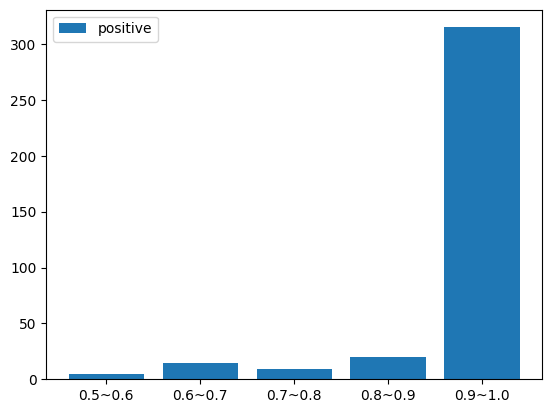

In [19]:
x = np.arange(5)
name = ['0.5~0.6', '0.6~0.7','0.7~0.8','0.8~0.9','0.9~1.0']
values = [pos1,pos2,pos3,pos4,pos5]

plt.bar(x, values,label="positive")
plt.xticks(x, name)
plt.legend()

plt.show()

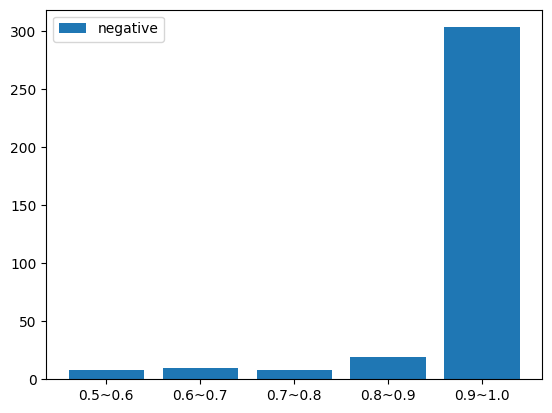

In [20]:
x = np.arange(5)
name = ['0.5~0.6', '0.6~0.7','0.7~0.8','0.8~0.9','0.9~1.0']
values = [neg1,neg2,neg3,neg4,neg5]

plt.bar(x, values,label="negative")
plt.legend()
plt.xticks(x, name)

plt.show()